In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [46]:

df = pd.read_excel("league_data.xlsx")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40410 entries, 0 to 40409
Data columns (total 94 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   game_id                                40410 non-null  int64         
 1   game_start_utc                         40410 non-null  datetime64[ns]
 2   game_duration                          40410 non-null  int64         
 3   game_mode                              40410 non-null  object        
 4   game_type                              40410 non-null  object        
 5   game_version                           40410 non-null  object        
 6   map_id                                 40410 non-null  int64         
 7   platform_id                            40410 non-null  object        
 8   queue_id                               40410 non-null  int64         
 9   participant_id                         40410 non-null  int64 

,game_id,game_start_utc,game_duration,map_id,queue_id,participant_id,summoner_level,champion_id,team_id,kills,...,final_magicPen,final_magicPenPercent,final_magicResist,final_movementSpeed,final_omnivamp,final_physicalVamp,final_power,final_powerMax,final_powerRegen,final_spellVamp
count,4.041000e+04,40410,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,40410.000000,...,40410.000000,40410.00000,40410.000000,40410.000000,40410.000000,40410.0,40410.000000,40410.000000,40410.000000,40410.000000
mean,3.725500e+09,2025-01-11 21:39:50.111358720,1581.655902,11.240782,430.002475,5.498144,393.328904,176.765429,149.962880,7.274091,...,5.653724,1.92638,71.650408,405.431106,0.043702,0.0,1024.290572,1257.735659,61.021975,0.005593
min,3.551580e+09,2024-02-17 16:03:00,101.000000,11.000000,400.000000,1.000000,2.000000,1.000000,100.000000,0.000000,...,0.000000,0.00000,-3.000000,129.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.727229e+09,2025-01-14 22:39:00,1277.000000,11.000000,420.000000,3.000000,201.000000,45.000000,100.000000,3.000000,...,0.000000,0.00000,48.000000,380.000000,0.000000,0.0,496.000000,783.000000,30.000000,0.000000
50%,3.728683e+09,2025-01-17 22:44:00,1618.000000,11.000000,420.000000,5.000000,360.000000,99.000000,100.000000,6.000000,...,0.000000,0.00000,54.000000,395.000000,0.000000,0.0,845.000000,1038.000000,41.000000,0.000000
75%,3.729385e+09,2025-01-19 08:19:00,1883.000000,11.000000,450.000000,8.000000,544.000000,203.000000,200.000000,10.000000,...,12.000000,0.00000,81.000000,415.000000,0.000000,0.0,1257.000000,1570.000000,67.000000,0.000000
max,3.730264e+09,2025-01-20 21:16:00,3307.000000,12.000000,890.000000,10.000000,2065.000000,950.000000,200.000000,48.000000,...,49.000000,48.00000,515.000000,1193.000000,25.000000,0.0,10000.000000,10000.000000,1013.000000,26.000000
std,1.755725e+07,NaN,477.051611,0.427563,22.964271,2.872316,251.874061,222.688428,50.000605,5.799235,...,11.022641,7.22606,38.658925,45.587867,0.674440,0.0,1209.163188,1207.966365,62.263617,0.376588


In League of Legends, there are a multitude of game modes to choose from. Since our problem wants to predict a W/L for a team in the Summoner's Rift classic game mode, the data should only contain data from that mode.

In [47]:
# Filter for CLASSIC game mode
df = df[df['game_mode'] == 'CLASSIC']

# Select only relevant columns
cols_to_keep = ['game_id', 'team_id', 'win', 'summoner_level', 'solo_tier', 'solo_rank', 'solo_lp', 'solo_wins', 'solo_losses', 'champion_mastery_points']

df = df[cols_to_keep]

# Confirm that each game_id has 10 rows associated (10 players per game)
player_counts = df.groupby("game_id").size()
player_counts.value_counts()
assert (player_counts == 10).all(), "Not all games have exactly 10 players"

# Confirm that each game_id:team_id has 5 rows associated (5 players per team)
player_counts = df.groupby(["game_id", "team_id"]).size()
player_counts.value_counts()
assert (player_counts == 5).all(), "Not all game_id:team_id combinations have exactly 5 players"

# Remove any games where all players in a game are unranked. If all players are unranked, we are unable to populate the player's rank with the mean rank for that game.
missing_all = df.groupby('game_id')['solo_tier'].apply(lambda s: s.isna().all())
bad_game_ids = missing_all[missing_all].index.tolist()
df = df[~df['game_id'].isin(bad_game_ids)]

# Find all unique rank tiers from the data set.
rank_tiers = df['solo_tier'].unique()

# Find all unique ranks from the data set.
rank = df['solo_rank'].unique()

# Normalize solo_tier, solo_rank, and solo_lp. We don't handle nan here since it will be handled in the next step.
tier_weights = {
    "IRON": 1,
    "BRONZE": 2,
    "SILVER": 3,
    "GOLD": 4,
    "PLATINUM": 5,
    "EMERALD": 6,
    "DIAMOND": 7,
    "MASTER": 8,
    "GRANDMASTER": 9,
    "CHALLENGER": 10
}

# Define numeric order of rank within the tier (I > II > III > IV)
rank_weights = {'I': 4, 'II': 3, 'III': 2, 'IV': 1}

tier_lp_offset = 400
rank_lp_offset = 100

df['solo_rank_normalized'] = (
    df['solo_tier'].map(tier_weights) * tier_lp_offset + 
    df['solo_rank'].map(rank_weights).fillna(1) * rank_lp_offset +
    df['solo_lp']
)

# For unranked players, fill in the solo_rank_normalized with the average solo_rank_normalized for that game_id
df.loc[df['solo_rank_normalized'].isna(), 'solo_rank_normalized'] = (
    df.groupby(['game_id'])['solo_rank_normalized']
      .transform(lambda s: s.fillna(s.mean()))
)

# Confirm that all players have a solo_rank_normalized
assert df['solo_rank_normalized'].isna().sum() == 0

# Drop the solo_tier, solo_rank, and solo_lp columns
df = df.drop(columns=['solo_tier', 'solo_rank', 'solo_lp'])

df['mean_win_loss_ratio'] = df['solo_wins'] / (df['solo_wins'] + df['solo_losses'])

# Handle the 0/0 case by setting it to 0.5 (neutral win rate)
df['mean_win_loss_ratio'] = df['mean_win_loss_ratio'].fillna(0.5)

team_df = df.groupby(['game_id', 'team_id', 'win']).agg({
    'summoner_level': 'mean',
    'mean_win_loss_ratio': 'mean',
    'champion_mastery_points': 'mean',
    'solo_rank_normalized': 'mean'
}).reset_index()

# rename the columns to mean_
team_df.rename(columns={
    'summoner_level': 'mean_summoner_level',
    'mean_win_loss_ratio': 'mean_win_loss_ratio',
    'champion_mastery_points': 'mean_champion_mastery_points',
    'solo_rank_normalized': 'mean_solo_rank_normalized'
}, inplace=True)

team_df.head()
features = team_df.columns.tolist()


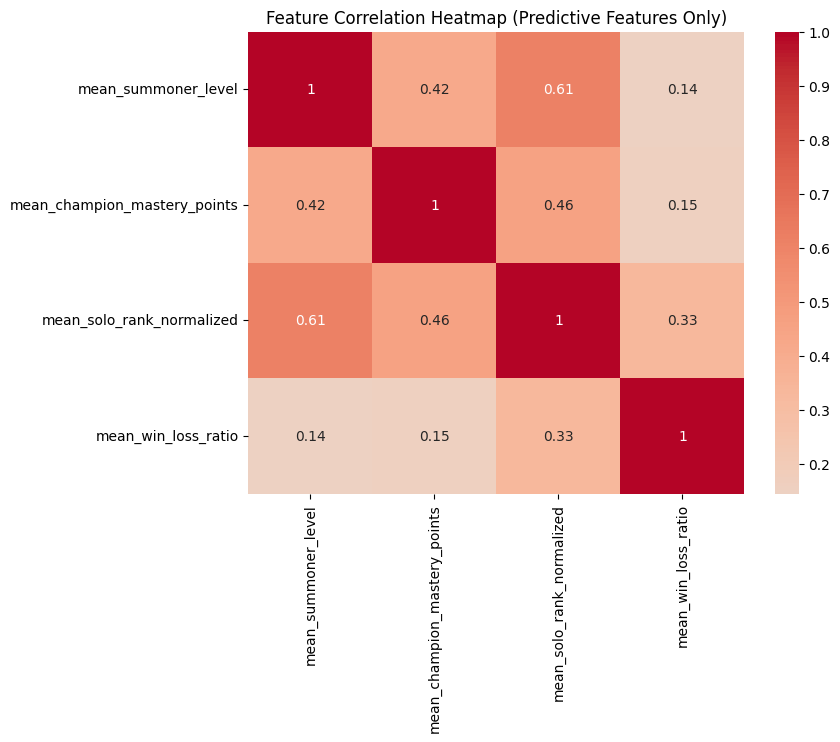

In [48]:
# Exclude game_id, team_id (identifiers) and win (target variable)
predictive_features = [
    'mean_summoner_level',
    'mean_champion_mastery_points',
    'mean_solo_rank_normalized',
    'mean_win_loss_ratio'
]

plt.figure(figsize=(8,6))
sns.heatmap(team_df[predictive_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Predictive Features Only)")
plt.show()


Model Accuracy: 0.5222

Classification Report:
              precision    recall  f1-score   support

       False       0.53      0.59      0.56       596
        True       0.52      0.45      0.48       576

    accuracy                           0.52      1172
   macro avg       0.52      0.52      0.52      1172
weighted avg       0.52      0.52      0.52      1172



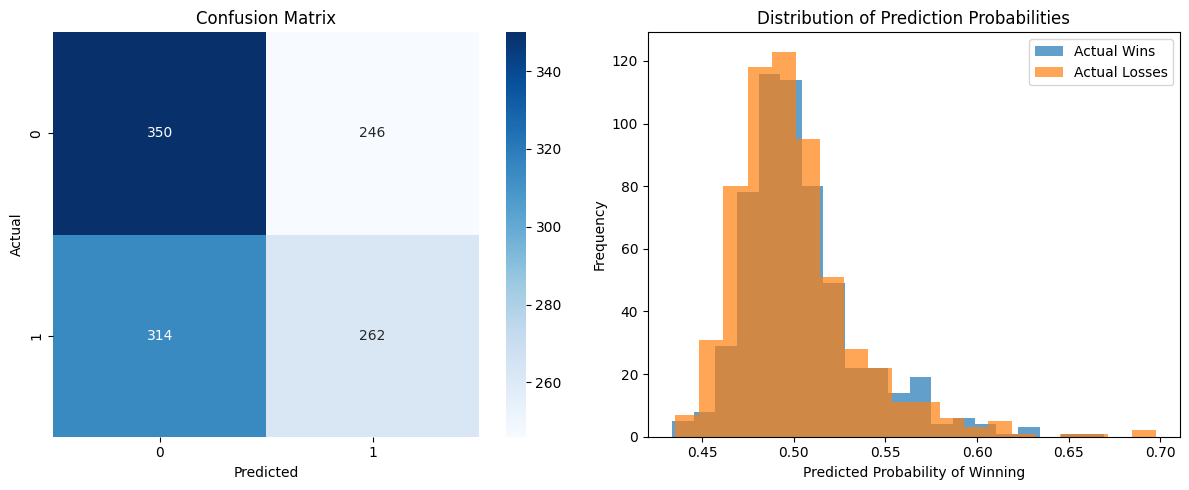

In [49]:
# Try a Logistic Regression Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(team_df[predictive_features], team_df['win'], test_size=0.2, random_state=42)

# Create a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)[:, 1]

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Plot 2: Prediction Probabilities Distribution
ax2.hist(prediction_proba[y_test == True], alpha=0.7, label='Actual Wins', bins=20)
ax2.hist(prediction_proba[y_test == False], alpha=0.7, label='Actual Losses', bins=20)
ax2.set_xlabel('Predicted Probability of Winning')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Prediction Probabilities')
ax2.legend()

plt.tight_layout()
plt.show()

In [50]:
# Create a pivot table to get team stats side by side
team_pivot = team_df.pivot(index='game_id', columns='team_id', values=['mean_solo_rank_normalized', 'mean_summoner_level', 'mean_champion_mastery_points'])

# Calculate differences (team 100 - team 200)
team_differences = pd.DataFrame({
    'rank_difference': team_pivot[('mean_solo_rank_normalized', 100)] - team_pivot[('mean_solo_rank_normalized', 200)],
    'level_difference': team_pivot[('mean_summoner_level', 100)] - team_pivot[('mean_summoner_level', 200)],
    'mastery_difference': team_pivot[('mean_champion_mastery_points', 100)] - team_pivot[('mean_champion_mastery_points', 200)]
}).reset_index()  # Reset index to make game_id a column

# Merge with original team_df
team_df_enhanced = team_df.merge(team_differences, on='game_id')

print("Enhanced features added (no warnings):")
print(team_df_enhanced.columns.tolist())

# Check the new features
print("\nSample of enhanced features:")
print(team_df_enhanced[['game_id', 'team_id', 'rank_difference', 'level_difference', 'mastery_difference']].head(10))

Enhanced features added (no warnings):
['game_id', 'team_id', 'win', 'mean_summoner_level', 'mean_win_loss_ratio', 'mean_champion_mastery_points', 'mean_solo_rank_normalized', 'rank_difference', 'level_difference', 'mastery_difference']

Sample of enhanced features:
      game_id  team_id  rank_difference  level_difference  mastery_difference
0  3551579567      100            -34.6            -100.6            -22835.2
1  3551579567      200            -34.6            -100.6            -22835.2
2  3551608175      100              0.0            -109.0            -85128.0
3  3551608175      200              0.0            -109.0            -85128.0
4  3554098287      100              0.0              35.2             55973.4
5  3554098287      200              0.0              35.2             55973.4
6  3554141997      100              0.0              76.6           -153446.8
7  3554141997      200              0.0              76.6           -153446.8
8  3554193949      100         

In [51]:
# Complete Model Comparison with Visualizations
# Enhanced feature set
enhanced_features = [
    'mean_summoner_level',
    'mean_champion_mastery_points', 
    'mean_solo_rank_normalized',
    'mean_win_loss_ratio',
    'rank_difference',
    'level_difference', 
    'mastery_difference'
]

# Prepare data
X = team_df_enhanced[enhanced_features]
y = team_df_enhanced['win']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True)
}

# Train models and collect metrics
model_results = {}
model_predictions = {}
model_probabilities = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    model_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba)
    }
    
    model_predictions[name] = y_pred
    model_probabilities[name] = y_proba

print("Model Performance Comparison:")
for name, metrics in model_results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")


Model Performance Comparison:

Logistic Regression:
  Accuracy: 0.6084
  Precision: 0.6119
  Recall: 0.6108
  Auc: 0.6474

Random Forest:
  Accuracy: 0.5717
  Precision: 0.5802
  Recall: 0.5448
  Auc: 0.6079

SVM:
  Accuracy: 0.6220
  Precision: 0.6345
  Recall: 0.5905
  Auc: 0.6643


<Figure size 1200x600 with 0 Axes>

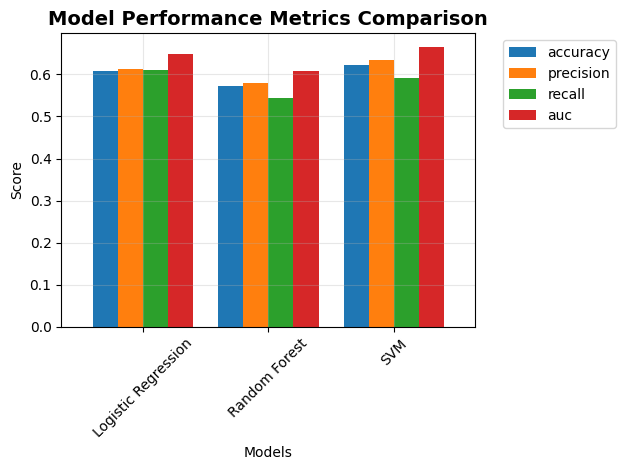

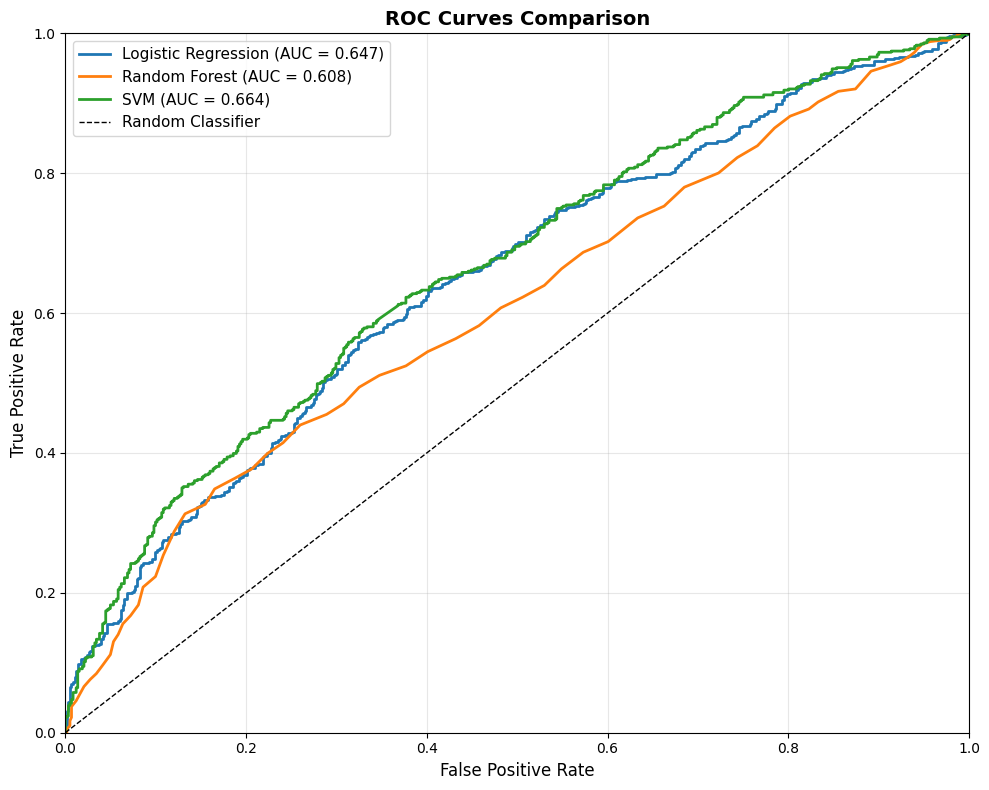

In [52]:
# Individual Model Comparison Charts

# 1. Metrics Comparison Bar Chart (Individual)
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame(model_results).T
metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. ROC Curves (Individual)
plt.figure(figsize=(10, 8))
for name, y_proba in model_probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = model_results[name]['auc']
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


In [53]:
# Fixed SVM Model with Hyperparameter Tuning

# Define the improved SVM with RBF kernel
nlsvm = SVC(kernel='rbf', C=1.0, gamma=1.0, probability=True)

# Cross-validation scores
scores = cross_val_score(nlsvm, X_scaled, y, cv=5, scoring="accuracy")
nlsvm.fit(X_scaled, y)

print("IMPROVED SVM MODEL")
print("Cross-val mean accuracy: {:.3f} (+/- {:.3f})".format(np.mean(scores), np.std(scores) * 2))

# Hyperparameter tuning with GridSearchCV
print("\nHYPERPARAMETER TUNING")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Train the best model
best_svm = grid_search.best_estimator_
best_svm.fit(X_scaled, y)

# Test the best model
y_pred_best = best_svm.predict(X_test)
y_proba_best = best_svm.predict_proba(X_test)[:, 1]

print("\nBEST SVM PERFORMANCE")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, y_proba_best):.4f}")


IMPROVED SVM MODEL
Cross-val mean accuracy: 0.614 (+/- 0.049)

HYPERPARAMETER TUNING
Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation score: 0.630

BEST SVM PERFORMANCE
Test Accuracy: 0.6596
Test AUC: 0.7153
